In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans
import os
import clean_data

In [2]:
import sys
sys.path.append('../')
import us_boundaries as usb

In [3]:
# savefile image name (or None, to not save) for the k-means clustering
states = ["CO","UT","NV","CA","AZ","NM"]  # all caps
state_names = ["Colorado","Utah","Nevada","California","Arizona","New Mexico"]  # full name (first letter capitalized)
savefile = "figs/" + "_".join(map(lambda x: x.lower(), states)) + "_kmeans.png"

In [6]:
# open data
ds = []

for state in states:
    data_file = "data/" + state + '.pickle'
    if os.path.exists(data_file):
        with open(data_file, 'rb') as handle:
            ds.append(pickle.load(handle))
    else:
        print(state + " data not found...scraping data into folder")
        clean_data.save_data(state)

## K Means

In [7]:
# use k-means, and find the cluster centers
kms = []
for i, d in enumerate(ds):
    km = KMeans(n_clusters=5,n_init='auto').fit(d['all_data'][:,2:]);
    kms.append(km)
    print(state_names[i])
    print(km.cluster_centers_)  # without lat lon coord as "features"

Colorado
[[0.61855784 0.452602   0.85888102 0.64129503]
 [0.31557678 0.43550972 0.95103075 0.62827397]
 [0.38624508 0.39254377 0.92448847 0.47650194]
 [0.49739486 0.28896171 0.91023147 0.58357083]
 [0.76368863 0.57265986 0.82416987 0.73791466]]
Utah
[[0.37978015 0.28249321 0.8738527  0.54181535]
 [0.40290071 0.21330733 0.88099149 0.73672547]
 [0.69621044 0.32435304 0.82311994 0.83611934]
 [0.57246262 0.56676999 0.81121791 0.67610688]
 [0.52726948 0.26981262 0.84767894 0.77896337]]
Nevada
[[0.06159854 0.32966363 0.88046492 0.38779941]
 [0.37552458 0.19646237 0.84030176 0.49041454]
 [0.502351   0.5424242  0.82294232 0.5409909 ]
 [0.19103216 0.1885735  0.91997844 0.61243694]
 [0.52135143 0.22540667 0.82338803 0.55197691]]
California
[[  0.12266059   0.13355635   0.89369084   0.50797713]
 [ -8.2105554  -13.08276585  -8.25619835   0.66059001]
 [ -8.21228325   0.22030776   0.85805612   0.49812068]
 [ -8.12511306   0.20326859  -8.25619835   0.522255  ]
 [  0.44415583   0.10302348   0.83030559

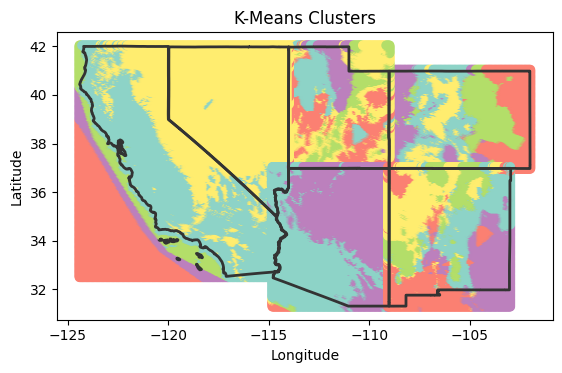

In [8]:
# plot the cluster of a specific (long,lat) coordinate
fig,ax = plt.subplots()
ax.set_xlabel("Longitude");
ax.set_ylabel("Latitude");
ax.set_title("K-Means Clusters");

for i,km in enumerate(kms):
    lon = np.round(ds[i]['lon'],2).flatten()  # x
    lat = np.round(ds[i]['lat'],2).flatten()  # y
    ax.scatter(lon,lat,c=km.labels_,cmap='Set3');

for state_name in state_names:
    usb.draw_state(ax, state_name, edgecolor='#333')

# if savefile:  # save if filename is given
#     plt.savefig(savefile,dpi=300);